Solution of the robust performance problem via $\mu$-synthesis.

Example from Skogestad & Postlethwaite 8.12.4
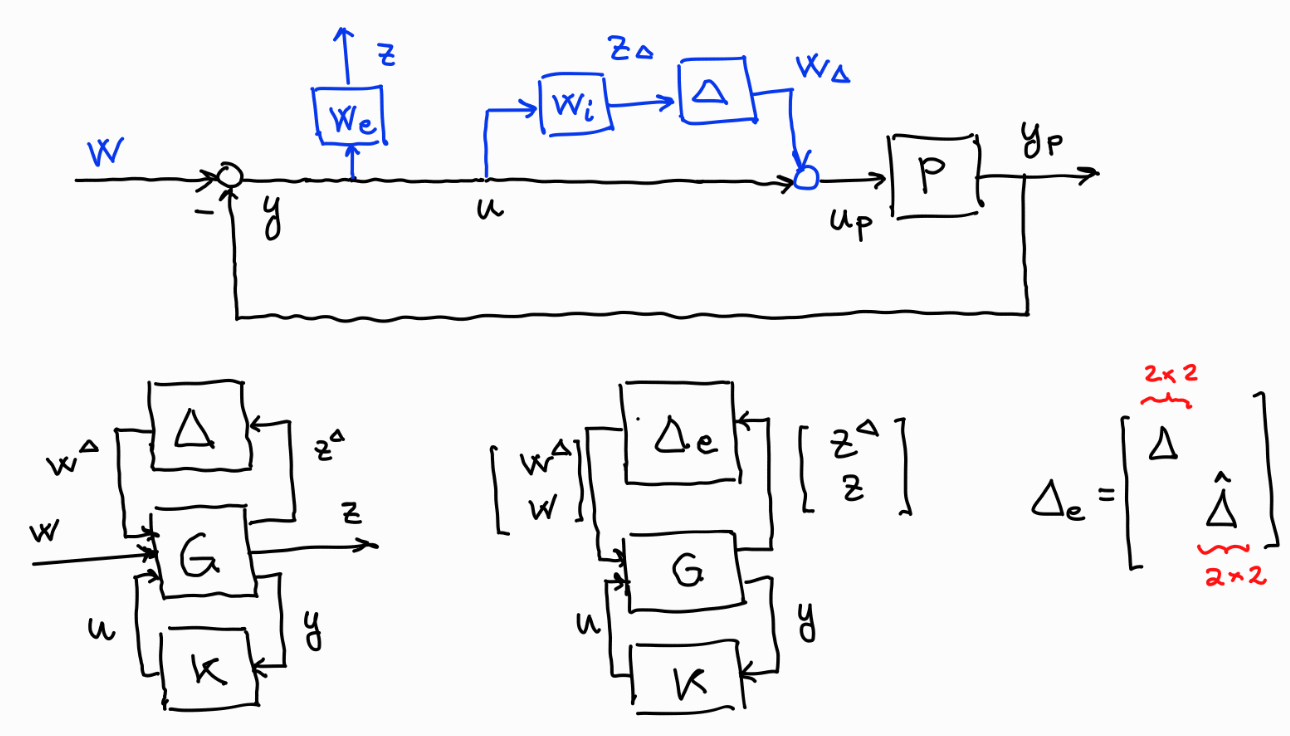

Plant uncertainty model is $P_p=P(I+\Delta W_i)$, with $W_i=w_i I$.

In [1]:
import matplotlib.pyplot as plt
from itertools import product
import slycot as sly
import numpy as np
import control as ct
import rpc_diism.robust as rb

In [2]:
# Plant P
den = [75, 1]
P = ct.tf([[[87.8], [-86.4]],
              [[108.2], [-109.6]]],
             [[den, den],
              [den, den]])
display("Plant transfer function", P)

'Plant transfer function'

TransferFunction(
[[array([87.8]), array([-86.4])],
 [array([108.2]), array([-109.6])]],
[[array([75,  1]), array([75,  1])],
 [array([75,  1]), array([75,  1])]],
outputs=2, inputs=2)

Define performance weight and uncertainty weight 

'Uncertainty weight'

TransferFunction(
[[array([1. , 0.2]), array([0.])],
 [array([0.]), array([1. , 0.2])]],
[[array([0.5, 1. ]), array([1.])],
 [array([1.]), array([0.5, 1. ])]],
outputs=2, inputs=2)

'Performance weight'

TransferFunction(
[[array([0.5 , 0.05]), array([0.])],
 [array([0.]), array([0.5 , 0.05])]],
[[array([1.e+00, 1.e-06]), array([1.])],
 [array([1.]), array([1.e+00, 1.e-06])]],
outputs=2, inputs=2)

Text(0.5, 1.0, 'Frequency response of uncertainty and performance weights Wi, We')

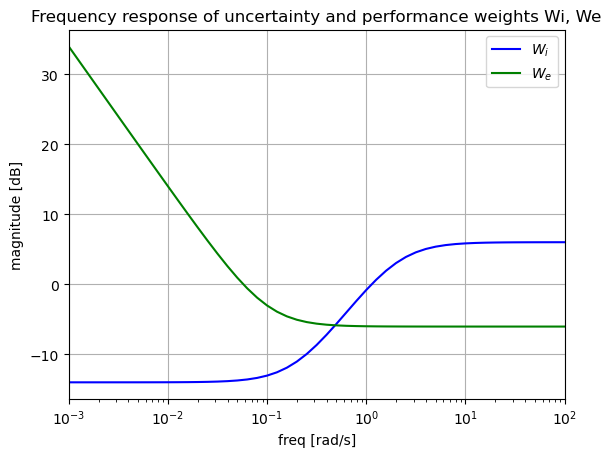

In [3]:
# Uncertainty block weight Wi
w_i = ct.tf([1,0.2],[0.5,1])
Wi = w_i.append(w_i) 
display("Uncertainty weight", Wi)

# Performance weight We (weight on S)
w_e = ct.tf([0.5,0.05],[1,1e-6])
We = w_e.append(w_e)
display("Performance weight", We)

# Frequency range for mu computations
omega = np.logspace(-3, 3, 61)

Wisv = rb.sigma(w_i, omega)
Wesv = rb.sigma(w_e, omega)

plt.semilogx(omega, 20*np.log10(Wisv[:, 0]), 'b', label=r'$W_i$')
plt.semilogx(omega, 20*np.log10(Wesv[:, 0]), 'g', label=r'$W_e$')
#plt.ylim([-60, 30])
plt.ylabel('magnitude [dB]')
plt.xlim([1e-3, 1e2])
plt.xlabel('freq [rad/s]')
plt.legend()
plt.grid()
plt.title('Frequency response of uncertainty and performance weights Wi, We')

Uncertainty model with $\|\Delta\|_\infty<1$ approximately accounts for a 20% gain error and a neglected time delay of 0.9 (time is in minutes)


Construct the LFT

In [4]:
Wi.input_labels = ['u[0]', 'u[1]']
Wi.output_labels = ['zdelta[0]', 'zdelta[1]']
We.input_labels = ['y[0]', 'y[1]']
We.output_labels = ['z[0]', 'z[1]']
P.input_labels = ['up[0]','up[1]']
P.output_labels = ['yp[0]','yp[1]']

# Summing junction (multiplicative uncertainty)
sumdelta = ct.summing_junction(inputs=['u','wdelta'], output='up', dimension=2)

# Feedback: y = r-yp
fbk = ct.summing_junction(inputs=['w','-yp'], output='y', dimension=2)

# Generate the G transfer function of the LFT
G = ct.minreal(ct.interconnect([P, Wi, We, sumdelta, fbk],
                    inputs=['wdelta[0]','wdelta[1]','w[0]','w[1]','u[0]','u[1]'],
                    outputs=['zdelta[0]','zdelta[1]','z[0]','z[1]','y[0]','y[1]']), 
                    verbose=False)

Do $\mu$-synthesis.

In [5]:
# Controller I/O sizes
f = 2

# Extended uncertainty structure: a 2x2 uncertainty block and a 2x2 performance block
nblock = np.array([2,2])
# This has to be == 2 (complex uncertainty) for each block (other values are not implemented)
itype = np.array([2,2])

# Do mu-synthesis via D-K iteration
K, best_nubar, init_mubar, best_mubar, gamma = rb.musyn(G, f, nblock, itype, omega, maxiter=20)

display("Best upper bound (nubar) to mu norm of Tzw_delta: ", best_nubar)

Infinity norm of Tzw_delta with initial Hinfinity controller:  1.1797776480193534
Iteration # 1
Best upper bound to mu norm of Tzw_delta:  1.179213590194008
Iteration # 2
Best upper bound to mu norm of Tzw_delta:  1.0400214160943242
Iteration # 3
No better upper bound to mu norm of Tzw_delta found: trying D order  5 qutol  1.0
Iteration # 4
Best upper bound to mu norm of Tzw_delta:  1.0213710230141588
Iteration # 5
No better upper bound to mu norm of Tzw_delta found: trying D order  5 qutol  1.0
Iteration # 6
No better upper bound to mu norm of Tzw_delta found: trying D order  6 qutol  1.0
Iteration # 7
No better upper bound to mu norm of Tzw_delta found: trying D order  7 qutol  1.0
Iteration # 8
No better upper bound to mu norm of Tzw_delta found: trying D order  8 qutol  1.0
Iteration # 9
No better upper bound to mu norm of Tzw_delta found: trying D order  4 qutol  2.0
Iteration # 10
No better upper bound to mu norm of Tzw_delta found: trying D order  5 qutol  2.0
Iteration # 11
No 

'Best upper bound (nubar) to mu norm of Tzw_delta: '

1.0213710230141588

Plot initial and final $\mu$ upper bound $\bar\mu$ with frequency

Text(0.5, 1.0, 'Initial and final $\\bar\\mu$')

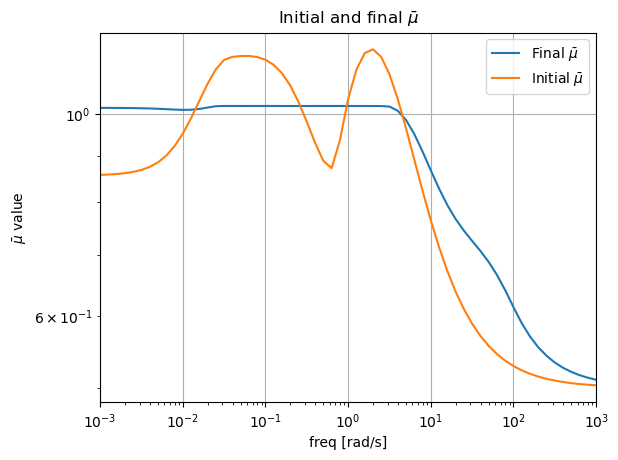

In [6]:
plt.loglog(omega, best_mubar, label=r'Final $\bar \mu$')
plt.loglog(omega, init_mubar, label=r'Initial $\bar \mu$')
plt.ylabel(r'$\bar\mu$ value')
plt.xlabel('freq [rad/s]')
plt.xlim([1e-3, 1e3])
plt.legend()
plt.grid()
plt.title(r'Initial and final $\bar\mu$')

Verify performance on the nominal system. It must hold that $\|W_e S\|_\infty \leq 1$ since $\bar\nu\approx 1$. More precisely, we have $\|W_e S\|_\infty \leq \bar\nu$.

Text(0.5, 1.0, 'Singular values of S vs. nubar*inv(We) for the nominal system')

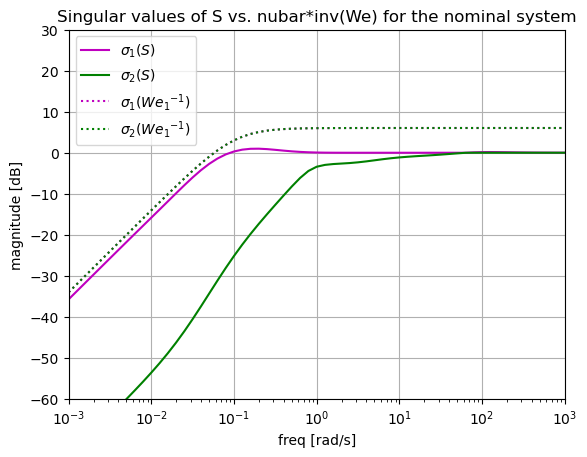

In [7]:
# Compute sensitivity for the nominal system
I = ct.ss([], [], [], np.eye(2)) # Identity system  
Delta = 0 * I
Delta.input_labels = ['zdelta[0]','zdelta[1]']
Delta.output_labels = ['wdelta[0]','wdelta[1]']               
K.input_labels = ['y[0]','y[1]']
K.output_labels = ['u[0]','u[1]'] 

S = ct.minreal(ct.interconnect([P, Delta, K, Wi, We, sumdelta, fbk],
                    inputs=['w[0]','w[1]'],
                    outputs=['y[0]','y[1]'], check_unused=False), verbose=False)

# Compute singular values of S over frequency
Ssv = rb.sigma(S, omega)

# Plot the singular values of gamma*invss(We) along with S
# for gamma = best_mu_upper_bound
Weinv = rb.invss(ct.ss(We))
Weinvsv = rb.sigma(Weinv, omega)

plt.semilogx(omega, 20*np.log10(Ssv[:, 0]), 'm', label=r'$\sigma_1(S)$')
plt.semilogx(omega, 20*np.log10(Ssv[:, 1]), 'g', label=r'$\sigma_2(S)$')
plt.semilogx(omega, 20*np.log10(Weinvsv[:, 0]), 'm:', label=r'$\sigma_1({We_1}^{-1})$')
plt.semilogx(omega, 20*np.log10(Weinvsv[:, 1]), 'g:', label=r'$\sigma_2({We_1}^{-1})$')
plt.ylim([-60, 30])
plt.ylabel('magnitude [dB]')
plt.xlim([1e-3, 1e3])
plt.xlabel('freq [rad/s]')
plt.legend()
plt.grid()
plt.title('Singular values of S vs. nubar*inv(We) for the nominal system')

Now we verify the performance under some admissible perturbations.

Since $W_e$ is 0.2 at low frequency, and the uncertainty model is $P_p=P(I+W_e\Delta)$ with $\|\Delta\|_\infty \leq 1$, considering that we have achieved a value of $\bar\nu\approx 1$, an input gain perturbation of $(I-0.2I)$ is admissible.

Text(0.5, 1.0, 'Singular values of S vs. nubar*inv(We) for perturbed system')

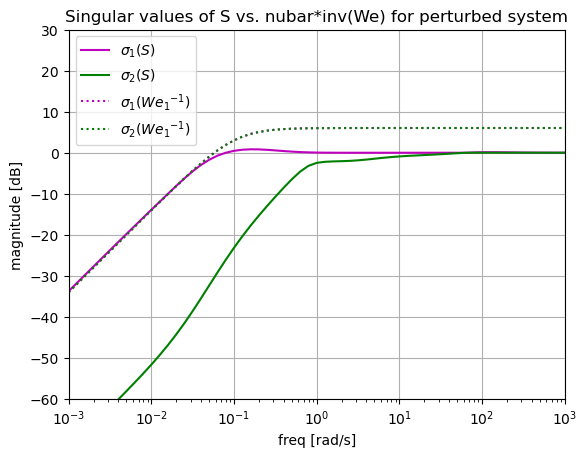

In [8]:
# Generate an admissible perturbed plan
Pp = P*(I-0.2*I)
Pp.input_labels = ['up[0]','up[1]']
Pp.output_labels = ['yp[0]','yp[1]']

# Sensitivity of perturbed system
Sp = ct.minreal(ct.interconnect([Pp, Delta, K, Wi, We, sumdelta, fbk],
                    inputs=['w[0]','w[1]'],
                    outputs=['y[0]','y[1]'], check_unused=False), verbose=False)

# Compute singular values of S over frequency
Spsv = rb.sigma(Sp, omega)

plt.semilogx(omega, 20*np.log10(Spsv[:, 0]), 'm', label=r'$\sigma_1(S)$')
plt.semilogx(omega, 20*np.log10(Spsv[:, 1]), 'g', label=r'$\sigma_2(S)$')
plt.semilogx(omega, 20*np.log10(Weinvsv[:, 0]), 'm:', label=r'$\sigma_1({We_1}^{-1})$')
plt.semilogx(omega, 20*np.log10(Weinvsv[:, 1]), 'g:', label=r'$\sigma_2({We_1}^{-1})$')
plt.ylim([-60, 30])
plt.ylabel('magnitude [dB]')
plt.xlim([1e-3, 1e3])
plt.xlabel('freq [rad/s]')
plt.legend()
plt.grid()
plt.title('Singular values of S vs. nubar*inv(We) for perturbed system')

If we want to be precise, the actual level of robust performance is $\|W_e S\|_\infty \leq \bar\nu$ for $\|\Delta\|<1/\bar\nu$ ,even if $\bar\nu$ is almost 1. Therefore we must compare $S$ with $\bar\nu W_e^{-1}$ for an admissible perturbation $P_p=P(I-0.2/\bar\nu I)$.

Text(0.5, 1.0, 'Singular values of S vs. nubar*inv(We) for perturbed system')

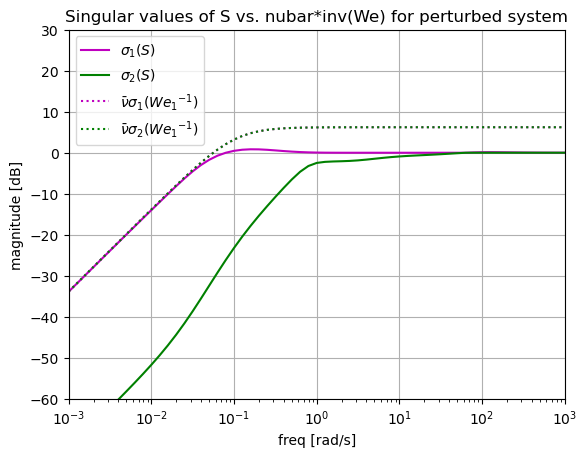

In [9]:
# Generate an admissible perturbed plant
Pp = P*(I-0.2/best_nubar*I)
Pp.input_labels = ['up[0]','up[1]']
Pp.output_labels = ['yp[0]','yp[1]']

# Sensitivity of perturbed system
Sp = ct.minreal(ct.interconnect([Pp, Delta, K, Wi, We, sumdelta, fbk],
                    inputs=['w[0]','w[1]'],
                    outputs=['y[0]','y[1]'], check_unused=False), verbose=False)

# Compute singular values of S over frequency
Spsv = rb.sigma(Sp, omega)

plt.semilogx(omega, 20*np.log10(Spsv[:, 0]), 'm', label=r'$\sigma_1(S)$')
plt.semilogx(omega, 20*np.log10(Spsv[:, 1]), 'g', label=r'$\sigma_2(S)$')
plt.semilogx(omega, 20*np.log10(best_nubar*Weinvsv[:, 0]), 'm:', label=r'$\bar\nu \sigma_1({We_1}^{-1})$')
plt.semilogx(omega, 20*np.log10(best_nubar*Weinvsv[:, 1]), 'g:', label=r'$\bar\nu  \sigma_2({We_1}^{-1})$')
plt.ylim([-60, 30])
plt.ylabel('magnitude [dB]')
plt.xlim([1e-3, 1e3])
plt.xlabel('freq [rad/s]')
plt.legend()
plt.grid()
plt.title('Singular values of S vs. nubar*inv(We) for perturbed system')

Apparently, we hit a particular case here. In fact, since $\sigma_1(S)$ is tight to $\bar\nu W_e^{-1}$, we have that $\|W_e S\|_\infty=\bar\nu$. This means two things: 1) The upper bound $\bar\nu$ is the "real" $\|T_{zw}\|_\mu$ here, i.e., there is no gap between the two; 2) The perturbation that we have chosen is almost the "worst" possible perturbation in the admissible set, because it causes the closed loop to sit on the boundary of the performance specification!

Another admissible perturbation is $P_p=P(I+D_p/\bar\nu)$, where $D_p=\frac{0.2-s}{1+0.5s} I$, note that $W_e$ and $D_p$ have the same frequency response singular values.

Text(0.5, 1.0, 'Singular values of S vs. nubar*inv(We) for perturbed system')

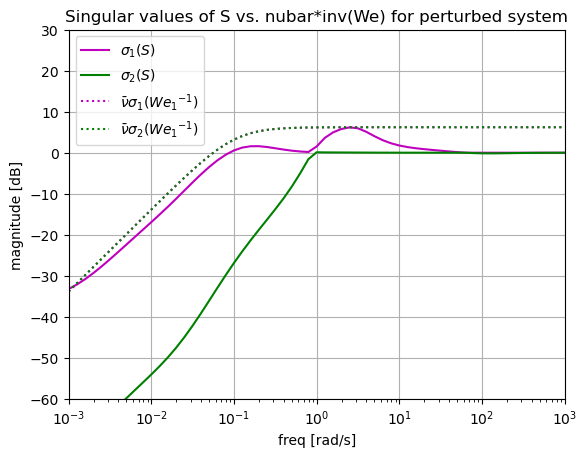

In [10]:
# Generate another admissible perturbed plant
Dp = 1/best_nubar * ct.tf([-1,0.2],[0.5,1])
Dp = Dp.append(Dp)

Pp2 = P*(I+Dp)
Pp2.input_labels = ['up[0]','up[1]']
Pp2.output_labels = ['yp[0]','yp[1]']

# Sensitivity of perturbed system
Sp2 = ct.minreal(ct.interconnect([Pp2, Delta, K, Wi, We, sumdelta, fbk],
                    inputs=['w[0]','w[1]'],
                    outputs=['y[0]','y[1]'], check_unused=False), verbose=False)

# Compute singular values of S over frequency
Spsv = rb.sigma(Sp2, omega)

plt.semilogx(omega, 20*np.log10(Spsv[:, 0]), 'm', label=r'$\sigma_1(S)$')
plt.semilogx(omega, 20*np.log10(Spsv[:, 1]), 'g', label=r'$\sigma_2(S)$')
plt.semilogx(omega, 20*np.log10(best_nubar*Weinvsv[:, 0]), 'm:', label=r'$\bar\nu \sigma_1({We_1}^{-1})$')
plt.semilogx(omega, 20*np.log10(best_nubar*Weinvsv[:, 1]), 'g:', label=r'$\bar\nu  \sigma_2({We_1}^{-1})$')
plt.ylim([-60, 30])
plt.ylabel('magnitude [dB]')
plt.xlim([1e-3, 1e3])
plt.xlabel('freq [rad/s]')
plt.legend()
plt.grid()
plt.title('Singular values of S vs. nubar*inv(We) for perturbed system')

Observe that also in this case, $\sigma_1(S)$ is tight to $\bar\nu W_e^{-1}$ and therefore $\bar\nu$ is the real $\|T_{zw}\|_\mu$.

Now, let's compare the step responses of the closed loop nominal and perturbed systems. Note that the steady state tracking error is almost independent of the perturbation. This is because the low-frequency sensitivity performance is ensured robustly and the actual sensitivity is very close to $\bar\nu|W_e^{-1}|$ at low frequencies in all cases!

Text(0.5, 1.0, 'Closed loop responses to reference [1,1]')

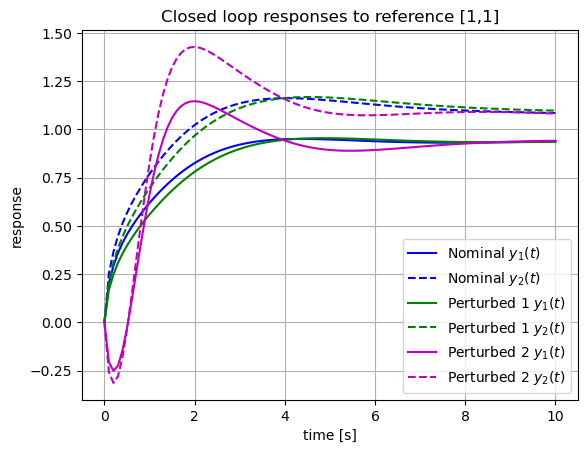

In [11]:
# Time for simulation
time = np.linspace(0, 10, 101)

# Compute complementary sensitivity for nominal, perturbed 1 and perturbed 2
T = I-S
Tp = I-Sp
Tp2 = I-Sp2

# Compute and plot unit step responses
_, y1 = ct.step_response(T, time, input=0, squeeze=True)
_, y2 = ct.step_response(T, time, input=1, squeeze=True)
y = y1+y2
_, yp1 = ct.step_response(Tp, time, input=0, squeeze=True)
_, yp2 = ct.step_response(Tp, time, input=1, squeeze=True)
yp= (yp1+yp2)
_, yp1_2 = ct.step_response(Tp2, time, input=0, squeeze=True)
_, yp2_2 = ct.step_response(Tp2, time, input=1, squeeze=True)
yp_2= (yp1_2+yp2_2)

plt.plot(time, y[0], 'b', label='Nominal $y_1(t)$')
plt.plot(time, y[1], 'b--', label='Nominal $y_2(t)$')
plt.plot(time, yp[0], 'g', label='Perturbed 1 $y_1(t)$')
plt.plot(time, yp[1], 'g--', label='Perturbed 1 $y_2(t)$')
plt.plot(time, yp_2[0], 'm', label='Perturbed 2 $y_1(t)$')
plt.plot(time, yp_2[1], 'm--', label='Perturbed 2 $y_2(t)$')
plt.xlabel('time [s]')
plt.ylabel('response')
plt.legend()
plt.grid()
plt.title('Closed loop responses to reference [1,1]')
